# Klasifikasi Teks Berita dengan LDA Feature Extraction dan SVM

Tugas ini bertujuan untuk melakukan **Klasifikasi Teks Berita** menggunakan:
- **LDA (Latent Dirichlet Allocation)** sebagai metode ekstraksi fitur
- **SVM (Support Vector Machine)** sebagai algoritma klasifikasi

## Tahapan Pengerjaan:
1. **Persiapan Data Berlabel** - Load dan split data training/testing
2. **Pra-pemrosesan Teks** - Data sudah di-preprocessing (kolom `stemming_indo`)
3. **Ekstraksi Fitur dengan LDA** - Transform teks menjadi distribusi topik
4. **Pelatihan Model SVM** - Latih classifier dengan fitur LDA
5. **Evaluasi Hasil** - Ukur performa dan bandingkan dengan TF-IDF

## 1. Import Libraries

In [47]:
# Import libraries untuk data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Import libraries untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries untuk text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Import LDA
from sklearn.decomposition import LatentDirichletAllocation

# Import SVM dan metrics
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, classification_report, confusion_matrix)

# Import untuk grid search
from sklearn.model_selection import GridSearchCV

print("✓ Libraries berhasil di-import")

✓ Libraries berhasil di-import


## 2. Load dan Eksplorasi Data

In [48]:
# Load dataset
df = pd.read_csv('datasets/df_preprocessing.csv')

# Tampilkan info dataset
print("="*50)
print("INFORMASI DATASET")
print("="*50)
print(f"Jumlah data: {len(df)}")
print(f"Jumlah kolom: {len(df.columns)}")
print(f"\nKolom-kolom:")
print(df.columns.tolist())

# Tampilkan beberapa baris pertama
print("\n" + "="*50)
print("5 BARIS PERTAMA DATA")
print("="*50)
df.head()

INFORMASI DATASET
Jumlah data: 1200
Jumlah kolom: 8

Kolom-kolom:
['Isi Berita', 'lwr_indo', 'clean_sw_indo', 'clean_stb_indo', 'clean_typo_indo', 'stemming_indo', 'tokenize_indo', 'Kategori Berita']

5 BARIS PERTAMA DATA


,Isi Berita,lwr_indo,clean_sw_indo,clean_stb_indo,clean_typo_indo,stemming_indo,tokenize_indo,Kategori Berita
0,KOMPAS.com - Menteri Pemuda dan Olahraga Erick...,kompas.com - menteri pemuda dan olahraga erick...,kompas.com - menteri pemuda olahraga erick tho...,kompas com menteri pemuda olahraga erick tho...,kompas com menteri pemuda olahraga erick thohi...,kompas com menteri pemuda olahraga erick thohi...,"['kompas', 'com', 'menteri', 'pemuda', 'olahra...",BOLA
1,"KOMPAS.com - Manajer Chelsea, Enzo Maresca men...","kompas.com - manajer chelsea, enzo maresca men...","kompas.com - manajer chelsea, enzo maresca men...",kompas com manajer chelsea enzo maresca meng...,kompas com manajer chelsea enzo maresca mengan...,kompas com manajer chelsea enzo maresca anggap...,"['kompas', 'com', 'manajer', 'chelsea', 'enzo'...",BOLA
2,"KOMPAS.com - Pelatih Liverpool, Arne Slot, men...","kompas.com - pelatih liverpool, arne slot, men...","kompas.com - pelatih liverpool, arne slot, men...",kompas com pelatih liverpool arne slot menga...,kompas com pelatih liverpool arne slot mengaku...,kompas com latih liverpool arne slot aku cryst...,"['kompas', 'com', 'latih', 'liverpool', 'arne'...",BOLA
3,KOMPAS.com - Hasil terbaru pekan kelima Liga I...,kompas.com - hasil terbaru pekan kelima liga i...,kompas.com - hasil terbaru pekan liga italia 2...,kompas com hasil terbaru pekan liga italia ...,kompas com hasil terbaru pekan liga italia per...,kompas com hasil baru pekan liga italia beda n...,"['kompas', 'com', 'hasil', 'baru', 'pekan', 'l...",BOLA
4,KOMPAS.com - Menteri Pemuda dan Olahraga Repub...,kompas.com - menteri pemuda dan olahraga repub...,kompas.com - menteri pemuda olahraga republik ...,kompas com menteri pemuda olahraga republik ...,kompas com menteri pemuda olahraga republik in...,kompas com menteri pemuda olahraga republik in...,"['kompas', 'com', 'menteri', 'pemuda', 'olahra...",BOLA


DISTRIBUSI KATEGORI BERITA
Kategori Berita
BOLA        200
MONEY       200
NEWS        200
OTOMOTIF    200
PROV        200
REGIONAL    200
Name: count, dtype: int64


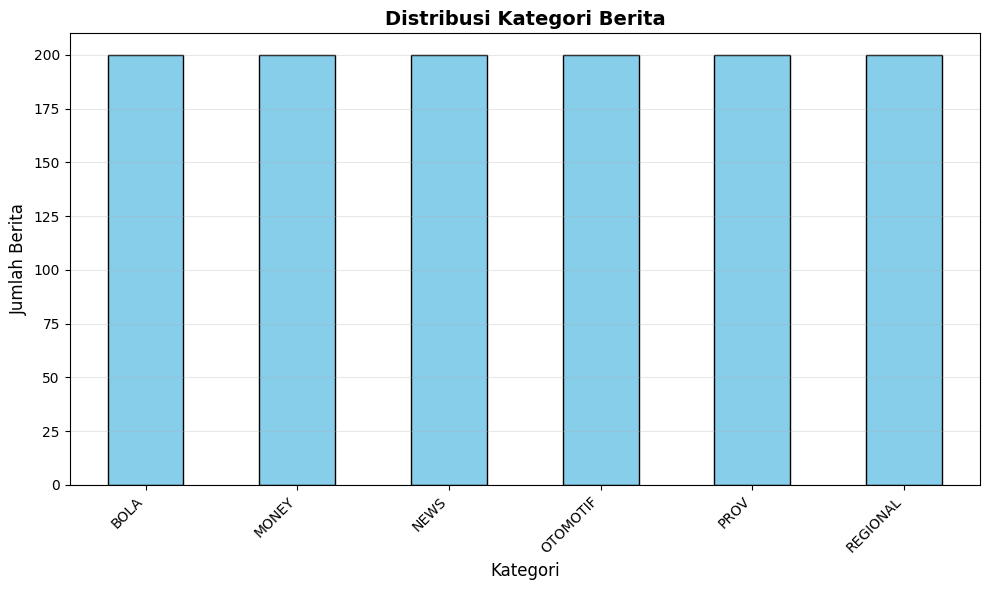


Jumlah kategori: 6


In [49]:
# Cek distribusi kategori berita
print("="*50)
print("DISTRIBUSI KATEGORI BERITA")
print("="*50)
kategori_dist = df['Kategori Berita'].value_counts()
print(kategori_dist)

# Visualisasi distribusi kategori
plt.figure(figsize=(10, 6))
kategori_dist.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribusi Kategori Berita', fontsize=14, fontweight='bold')
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Jumlah Berita', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nJumlah kategori: {df['Kategori Berita'].nunique()}")

## 3. Persiapan Data untuk Klasifikasi

Menggunakan kolom `stemming_indo` sebagai corpus (sudah di-preprocessing) dan `Kategori Berita` sebagai label.

In [50]:
# Ambil corpus dan label
corpus = df['stemming_indo'].astype(str).tolist()
labels = df['Kategori Berita'].tolist()

print("="*50)
print("PERSIAPAN DATA")
print("="*50)
print(f"Jumlah dokumen: {len(corpus)}")
print(f"Jumlah label: {len(labels)}")
print(f"\nContoh dokumen pertama:")
print(corpus[0][:200] + "...")
print(f"\nLabel pertama: {labels[0]}")

PERSIAPAN DATA
Jumlah dokumen: 1200
Jumlah label: 1200

Contoh dokumen pertama:
kompas com menteri pemuda olahraga erick thohir langsung gebrak minggu minggu jabat resmi cabut permenpora no tuai polemik kalang laku olahraga menpora erick thohir deregulasi besar besar mangkas atur...

Label pertama: BOLA


In [51]:
# Split data menjadi training dan testing (80:20)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    corpus, 
    labels, 
    test_size=0.2, 
    random_state=42,
    stratify=labels  # Memastikan proporsi kategori sama di train dan test
)

print("="*50)
print("PEMBAGIAN DATA TRAINING DAN TESTING")
print("="*50)
print(f"Jumlah data training: {len(X_train_text)}")
print(f"Jumlah data testing: {len(X_test_text)}")
print(f"\nProporsi pembagian: {len(X_train_text)/len(corpus)*100:.1f}% training, {len(X_test_text)/len(corpus)*100:.1f}% testing")

# Cek distribusi kategori di data training dan testing
print("\n" + "="*50)
print("DISTRIBUSI KATEGORI DI DATA TRAINING")
print("="*50)
print(pd.Series(y_train).value_counts())

print("\n" + "="*50)
print("DISTRIBUSI KATEGORI DI DATA TESTING")
print("="*50)
print(pd.Series(y_test).value_counts())

PEMBAGIAN DATA TRAINING DAN TESTING
Jumlah data training: 960
Jumlah data testing: 240

Proporsi pembagian: 80.0% training, 20.0% testing

DISTRIBUSI KATEGORI DI DATA TRAINING
MONEY       160
NEWS        160
PROV        160
BOLA        160
OTOMOTIF    160
REGIONAL    160
Name: count, dtype: int64

DISTRIBUSI KATEGORI DI DATA TESTING
BOLA        40
PROV        40
REGIONAL    40
NEWS        40
MONEY       40
OTOMOTIF    40
Name: count, dtype: int64


## 4. Ekstraksi Fitur Menggunakan LDA

### 4.1 Membuat Vocabulary dengan CountVectorizer

Kita akan menggunakan filtering frekuensi untuk mendapatkan vocabulary yang berkualitas:
- `min_df`: Kata harus muncul minimal di beberapa dokumen
- `max_df`: Kata tidak boleh muncul di terlalu banyak dokumen (untuk menghindari kata umum)

In [52]:
# Membuat vocabulary dengan CountVectorizer
# min_df=5: kata harus muncul minimal di 5 dokumen
# max_df=0.8: kata tidak boleh muncul di lebih dari 80% dokumen
vectorizer = CountVectorizer(
    min_df=5,           # Minimum document frequency
    max_df=0.8,         # Maximum document frequency (untuk filter kata terlalu umum)
    max_features=5000   # Batasi jumlah fitur maksimal
)

# Fit dan transform data training
X_train_counts = vectorizer.fit_transform(X_train_text)

# Transform data testing (gunakan vocabulary yang sama dari training)
X_test_counts = vectorizer.transform(X_test_text)

print("="*50)
print("VOCABULARY INFORMATION")
print("="*50)
print(f"Ukuran vocabulary: {len(vectorizer.vocabulary_)}")
print(f"Bentuk matrix training: {X_train_counts.shape}")
print(f"Bentuk matrix testing: {X_test_counts.shape}")
print(f"\nContoh 10 kata pertama dalam vocabulary:")
print(list(vectorizer.vocabulary_.keys())[:10])

VOCABULARY INFORMATION
Ukuran vocabulary: 3663
Bentuk matrix training: (960, 3663)
Bentuk matrix testing: (240, 3663)

Contoh 10 kata pertama dalam vocabulary:
['jakarta', 'indeks', 'harga', 'saham', 'gabung', 'ihsg', 'kuat', 'gerak', 'zona', 'hijau']


### 4.2 Menentukan Jumlah Topik Optimal dengan Coherence Score

Kita akan mencoba beberapa nilai k (jumlah topik) dan menghitung coherence score untuk setiap k.

In [53]:
# Fungsi untuk menghitung perplexity score
# Perplexity: Semakin rendah, semakin baik model
def compute_perplexity(lda_model, data):
    return lda_model.perplexity(data)

# Mencoba beberapa jumlah topik
topic_range = [5, 10, 15, 20, 25, 30]
perplexity_scores = []

print("="*50)
print("MENCARI JUMLAH TOPIK OPTIMAL")
print("="*50)

for n_topics in topic_range:
    print(f"Mencoba k={n_topics} topik...")
    
    # Train LDA dengan k topik
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=1000,
        learning_method='batch',
        n_jobs=-1
    )
    lda.fit(X_train_counts)
    
    # Hitung perplexity
    perplexity = compute_perplexity(lda, X_train_counts)
    perplexity_scores.append(perplexity)
    
    print(f"  Perplexity: {perplexity:.2f}")

print("\n✓ Selesai menghitung perplexity untuk berbagai jumlah topik")

MENCARI JUMLAH TOPIK OPTIMAL
Mencoba k=5 topik...
  Perplexity: 1255.00
Mencoba k=10 topik...
  Perplexity: 1255.00
Mencoba k=10 topik...
  Perplexity: 1146.88
Mencoba k=15 topik...
  Perplexity: 1146.88
Mencoba k=15 topik...
  Perplexity: 1099.68
Mencoba k=20 topik...
  Perplexity: 1099.68
Mencoba k=20 topik...
  Perplexity: 1057.90
Mencoba k=25 topik...
  Perplexity: 1057.90
Mencoba k=25 topik...
  Perplexity: 1020.32
Mencoba k=30 topik...
  Perplexity: 1020.32
Mencoba k=30 topik...
  Perplexity: 1017.01

✓ Selesai menghitung perplexity untuk berbagai jumlah topik
  Perplexity: 1017.01

✓ Selesai menghitung perplexity untuk berbagai jumlah topik


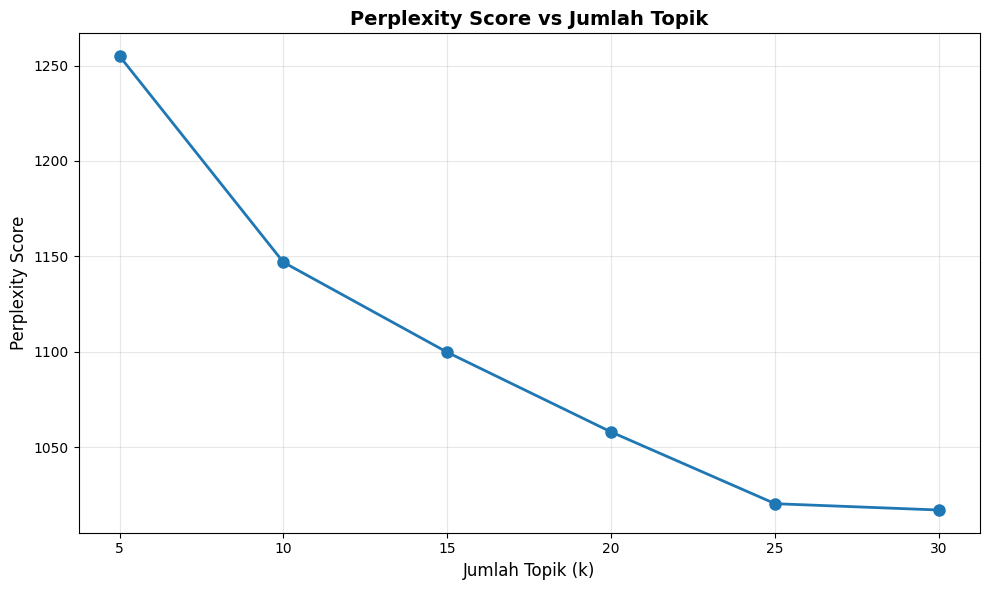


✓ Jumlah topik optimal (berdasarkan perplexity): 30


In [54]:
# Visualisasi Perplexity Score
plt.figure(figsize=(10, 6))
plt.plot(topic_range, perplexity_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('Jumlah Topik (k)', fontsize=12)
plt.ylabel('Perplexity Score', fontsize=12)
plt.title('Perplexity Score vs Jumlah Topik', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(topic_range)
plt.tight_layout()
plt.show()

# Pilih jumlah topik dengan perplexity terendah
optimal_topics = topic_range[np.argmin(perplexity_scores)]
print(f"\n✓ Jumlah topik optimal (berdasarkan perplexity): {optimal_topics}")

### 4.3 Melatih Model LDA dengan Jumlah Topik Optimal

In [55]:
# Latih model LDA final dengan jumlah topik optimal
print("="*50)
print(f"MELATIH MODEL LDA DENGAN {optimal_topics} TOPIK")
print("="*50)

lda_model = LatentDirichletAllocation(
    n_components=optimal_topics,
    random_state=0,
    max_iter=1000,  # Lebih banyak iterasi untuk model final
    learning_method='batch',
    n_jobs=-1,
    verbose=1
)

# Fit model LDA pada data training
lda_model.fit(X_train_counts)

print(f"\n✓ Model LDA berhasil dilatih dengan {optimal_topics} topik")

MELATIH MODEL LDA DENGAN 30 TOPIK
iteration: 1 of max_iter: 1000
iteration: 2 of max_iter: 1000
iteration: 1 of max_iter: 1000
iteration: 2 of max_iter: 1000
iteration: 3 of max_iter: 1000
iteration: 4 of max_iter: 1000
iteration: 3 of max_iter: 1000
iteration: 4 of max_iter: 1000
iteration: 5 of max_iter: 1000
iteration: 6 of max_iter: 1000
iteration: 5 of max_iter: 1000
iteration: 6 of max_iter: 1000
iteration: 7 of max_iter: 1000
iteration: 8 of max_iter: 1000
iteration: 7 of max_iter: 1000
iteration: 8 of max_iter: 1000
iteration: 9 of max_iter: 1000
iteration: 10 of max_iter: 1000
iteration: 9 of max_iter: 1000
iteration: 10 of max_iter: 1000
iteration: 11 of max_iter: 1000
iteration: 12 of max_iter: 1000
iteration: 11 of max_iter: 1000
iteration: 12 of max_iter: 1000
iteration: 13 of max_iter: 1000
iteration: 14 of max_iter: 1000
iteration: 13 of max_iter: 1000
iteration: 14 of max_iter: 1000
iteration: 15 of max_iter: 1000
iteration: 16 of max_iter: 1000
iteration: 15 of max_ite

In [56]:
# Tampilkan top words untuk setiap topik
def display_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append((topic_idx, top_words))
    return topics

# Get feature names dari vectorizer
feature_names = vectorizer.get_feature_names_out()

# Tampilkan topik-topik
print("="*50)
print("TOP 10 KATA PER TOPIK")
print("="*50)

topics = display_topics(lda_model, feature_names, n_top_words=10)
for topic_idx, top_words in topics:
    print(f"\nTopik {topic_idx}:")
    print(", ".join(top_words))

TOP 10 KATA PER TOPIK

Topik 0:
harga, emas, rp, gram, antam, foto, gadai, fitur, liter, jual

Topik 1:
bumn, bp, bca, pppk, sim, status, posisi, layan, usaha, badan

Topik 2:
terima, nomor, wajib, undang, sosial, bantu, bansos, puasa, data, atur

Topik 3:
korea, indonesia, open, jepang, ajar, putra, hasil, wakil, alwi, tunggal

Topik 4:
polri, menteri, reformasi, tim, komite, bentuk, perintah, pers, kait, kembali

Topik 5:
tni, indonesia, olahraga, erick, jakarta, thohir, pesawat, anak, garuda, tambah

Topik 6:
listrik, tarif, subsidi, perintah, langgan, rp, pln, menteri, naik, masyarakat

Topik 7:
jakarta, jalan, tol, lintas, macet, kota, tutup, gerbang, kendara, gt

Topik 8:
bbm, spbu, shell, pertamina, bakar, bahan, mobil, milik, mesin, swasta

Topik 9:
bank, ballon, dembele, or, ojk, asuransi, uang, raih, perban, ousmane

Topik 10:
tani, desa, kabupaten, tambang, kawasan, jalan, sebut, nasional, tanah, masyarakat

Topik 11:
korban, sangka, laku, polisi, duga, hukum, lapor, polda, 

### 4.4 Ekstraksi Fitur: Transformasi Dokumen ke Distribusi Topik (θ)

In [57]:
# Transform dokumen menjadi distribusi topik
# Setiap dokumen akan direpresentasikan sebagai vektor probabilitas topik
X_train_lda = lda_model.transform(X_train_counts)
X_test_lda = lda_model.transform(X_test_counts)

print("="*50)
print("EKSTRAKSI FITUR LDA")
print("="*50)
print(f"Bentuk fitur LDA training: {X_train_lda.shape}")
print(f"Bentuk fitur LDA testing: {X_test_lda.shape}")
print(f"\nSetiap dokumen kini direpresentasikan sebagai vektor dengan {optimal_topics} dimensi")
print("(probabilitas dokumen terkait dengan setiap topik)")

# Contoh distribusi topik untuk dokumen pertama
print(f"\n" + "="*50)
print("CONTOH DISTRIBUSI TOPIK DOKUMEN PERTAMA")
print("="*50)
for i, prob in enumerate(X_train_lda[0]):
    print(f"Topik {i}: {prob:.4f}")
    
print(f"\nTotal probabilitas: {X_train_lda[0].sum():.4f} (harus = 1.0)")

EKSTRAKSI FITUR LDA
Bentuk fitur LDA training: (960, 30)
Bentuk fitur LDA testing: (240, 30)

Setiap dokumen kini direpresentasikan sebagai vektor dengan 30 dimensi
(probabilitas dokumen terkait dengan setiap topik)

CONTOH DISTRIBUSI TOPIK DOKUMEN PERTAMA
Topik 0: 0.0002
Topik 1: 0.0002
Topik 2: 0.0002
Topik 3: 0.0002
Topik 4: 0.0002
Topik 5: 0.0002
Topik 6: 0.0002
Topik 7: 0.0002
Topik 8: 0.0002
Topik 9: 0.0002
Topik 10: 0.0002
Topik 11: 0.0002
Topik 12: 0.0002
Topik 13: 0.0002
Topik 14: 0.2945
Topik 15: 0.0002
Topik 16: 0.0002
Topik 17: 0.0002
Topik 18: 0.0002
Topik 19: 0.0002
Topik 20: 0.0002
Topik 21: 0.0002
Topik 22: 0.0002
Topik 23: 0.0002
Topik 24: 0.0002
Topik 25: 0.7000
Topik 26: 0.0002
Topik 27: 0.0002
Topik 28: 0.0002
Topik 29: 0.0002

Total probabilitas: 1.0000 (harus = 1.0)


## 5. Pelatihan Model Klasifikasi (SVM)
Melatih SVM menggunakan fitur LDA yang sudah diekstraksi.

In [58]:
# Latih SVM dengan fitur LDA
print("="*50)
print("MELATIH MODEL SVM DENGAN FITUR LDA")
print("="*50)

svm_lda = SVC(kernel='rbf', random_state=42, verbose=True)
svm_lda.fit(X_train_lda, y_train)

print("\n✓ Model SVM berhasil dilatih dengan fitur LDA")

MELATIH MODEL SVM DENGAN FITUR LDA
[LibSVM]
✓ Model SVM berhasil dilatih dengan fitur LDA


In [59]:
# Prediksi pada data testing
y_pred_lda = svm_lda.predict(X_test_lda)

print("="*50)
print("PREDIKSI SELESAI")
print("="*50)
print(f"Jumlah prediksi: {len(y_pred_lda)}")
print(f"\nContoh 10 prediksi pertama:")
for i in range(10):
    print(f"Aktual: {y_test[i]:15} | Prediksi: {y_pred_lda[i]}")

PREDIKSI SELESAI
Jumlah prediksi: 240

Contoh 10 prediksi pertama:
Aktual: BOLA            | Prediksi: OTOMOTIF
Aktual: PROV            | Prediksi: PROV
Aktual: REGIONAL        | Prediksi: PROV
Aktual: NEWS            | Prediksi: REGIONAL
Aktual: PROV            | Prediksi: REGIONAL
Aktual: MONEY           | Prediksi: MONEY
Aktual: MONEY           | Prediksi: MONEY
Aktual: MONEY           | Prediksi: MONEY
Aktual: BOLA            | Prediksi: BOLA
Aktual: PROV            | Prediksi: REGIONAL


## 6. Evaluasi Hasil Klasifikasi (LDA + SVM)

In [60]:
# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT (LDA + SVM)")
print("="*50)
print(classification_report(y_test, y_pred_lda, zero_division=0))


CLASSIFICATION REPORT (LDA + SVM)
              precision    recall  f1-score   support

        BOLA       0.90      0.88      0.89        40
       MONEY       0.85      0.82      0.84        40
        NEWS       0.58      0.55      0.56        40
    OTOMOTIF       0.84      0.93      0.88        40
        PROV       0.52      0.33      0.40        40
    REGIONAL       0.51      0.70      0.59        40

    accuracy                           0.70       240
   macro avg       0.70      0.70      0.69       240
weighted avg       0.70      0.70      0.69       240



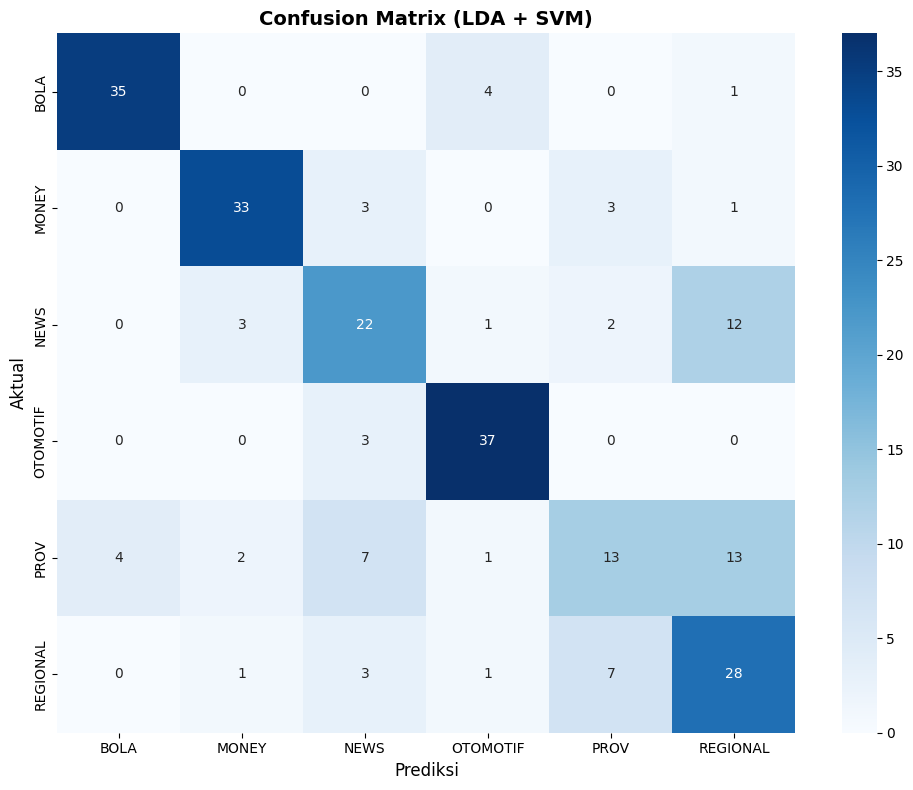

In [61]:
# Confusion Matrix
cm_lda = confusion_matrix(y_test, y_pred_lda)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(set(y_test)), 
            yticklabels=sorted(set(y_test)))
plt.title('Confusion Matrix (LDA + SVM)', fontsize=14, fontweight='bold')
plt.ylabel('Aktual', fontsize=12)
plt.xlabel('Prediksi', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Perbandingan dengan TF-IDF (Baseline)

Untuk menunjukkan efektivitas LDA, kita akan membandingkan hasilnya dengan metode TF-IDF sebagai baseline.

### 7.1 Ekstraksi Fitur dengan TF-IDF

In [62]:
# Ekstraksi fitur dengan TF-IDF
print("="*50)
print("EKSTRAKSI FITUR DENGAN TF-IDF")
print("="*50)

tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.8,
    max_features=5000
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print(f"Bentuk fitur TF-IDF training: {X_train_tfidf.shape}")
print(f"Bentuk fitur TF-IDF testing: {X_test_tfidf.shape}")
print(f"\n✓ Ekstraksi fitur TF-IDF selesai")

EKSTRAKSI FITUR DENGAN TF-IDF
Bentuk fitur TF-IDF training: (960, 3663)
Bentuk fitur TF-IDF testing: (240, 3663)

✓ Ekstraksi fitur TF-IDF selesai
Bentuk fitur TF-IDF training: (960, 3663)
Bentuk fitur TF-IDF testing: (240, 3663)

✓ Ekstraksi fitur TF-IDF selesai


### 7.2 Pelatihan SVM dengan Fitur TF-IDF

In [63]:
# Latih SVM dengan fitur TF-IDF
print("="*50)
print("MELATIH MODEL SVM DENGAN FITUR TF-IDF")
print("="*50)

svm_tfidf = SVC(kernel='rbf', random_state=42, verbose=True)
svm_tfidf.fit(X_train_tfidf, y_train)

print("\n✓ Model SVM berhasil dilatih dengan fitur TF-IDF")

# Prediksi
y_pred_tfidf = svm_tfidf.predict(X_test_tfidf)
print("✓ Prediksi selesai")

MELATIH MODEL SVM DENGAN FITUR TF-IDF
[LibSVM]
✓ Model SVM berhasil dilatih dengan fitur TF-IDF

✓ Model SVM berhasil dilatih dengan fitur TF-IDF
✓ Prediksi selesai
✓ Prediksi selesai


### 7.3 Evaluasi Hasil TF-IDF

In [64]:
# Classification Report untuk TF-IDF
print("\n" + "="*50)
print("CLASSIFICATION REPORT (TF-IDF + SVM)")
print("="*50)
print(classification_report(y_test, y_pred_tfidf, zero_division=0))


CLASSIFICATION REPORT (TF-IDF + SVM)
              precision    recall  f1-score   support

        BOLA       0.90      0.88      0.89        40
       MONEY       0.89      0.82      0.86        40
        NEWS       0.72      0.82      0.77        40
    OTOMOTIF       0.88      0.95      0.92        40
        PROV       0.62      0.40      0.48        40
    REGIONAL       0.67      0.82      0.74        40

    accuracy                           0.78       240
   macro avg       0.78      0.78      0.78       240
weighted avg       0.78      0.78      0.78       240



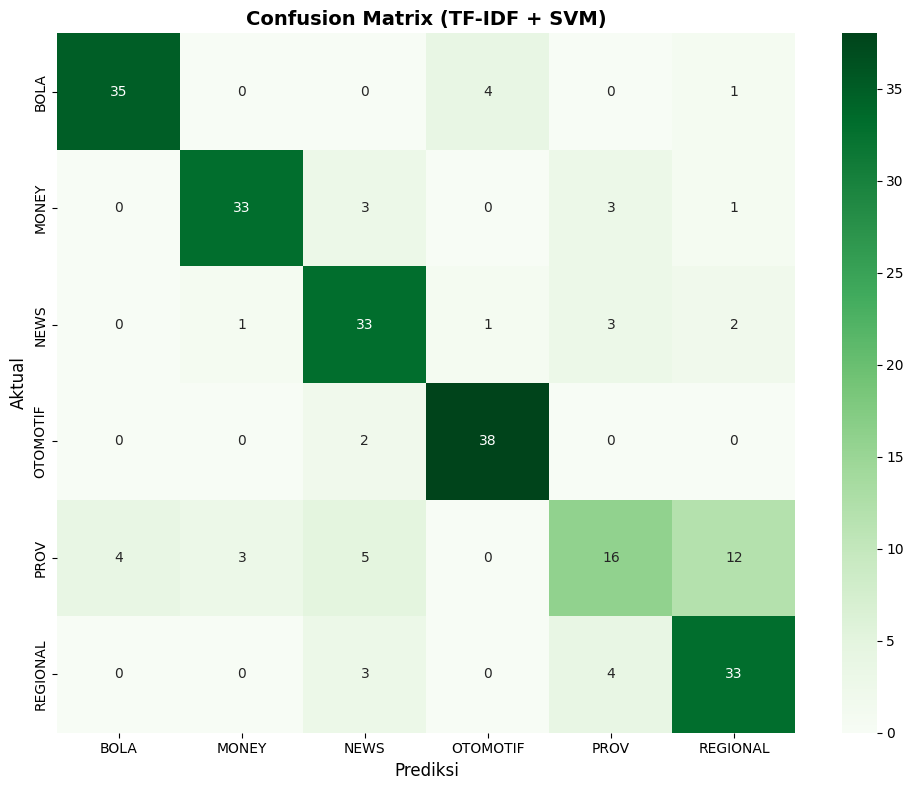

In [65]:
# Confusion Matrix untuk TF-IDF
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=sorted(set(y_test)), 
            yticklabels=sorted(set(y_test)))
plt.title('Confusion Matrix (TF-IDF + SVM)', fontsize=14, fontweight='bold')
plt.ylabel('Aktual', fontsize=12)
plt.xlabel('Prediksi', fontsize=12)
plt.tight_layout()
plt.show()